In [28]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 6      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [29]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.created, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

['0x2546c553d857d20658ece248f7c7d0861a240681', '0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0', '0x89f12aba0bcda3e708b1129eb2557b96f57b0de6', '0x734df7809c4ef94da037449c287166d114503198', '0xf353bda16a83399c11e09615ee7ac326a5a08ccf']
{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a24068100710e9c', 1757065107, '0xabe515f32991d6cf9122c56b8046368bbef16dd9e53f6d481554fb9cb0db27e6', 0.8001), ('0x2546c553d857d20658ece248f7c7d0861a240681964ef0c0', 1757065095, '0xf1141948f4001bae03b220ca8cc7cd23345c6e2757c6184e1b750c8d76a19eeb', 0.800404519), ('0x2546c553d857d20658ece248f7c7d0861a24068176eb203d', 1757065085, '0xd2e9db555003dd1da77a0143733d8bc4169399580a9fe38d8d074774344d2bc0', 0.500393112), ('0x2546c553d857d20658ece248f7c7d0861a24068197ed57c7', 1757065073, '0xef907973498d94b32135bba703c0c2d9fc995f6078950ceefdbc2314dcfa8894', 0.800404432), ('0x2546c553d857d20658ece248f7c7d0861a24068100872332', 1757065063, '0xc5b22b9f39f3a9c4f8ffdc2650c88e6a420c13dfa91dbcfee902

In [ ]:
# blacklist = [
#     "0x734df7809c4ef94da037449c287166d114503198",
#     # "0x89f12aba0bcda3e708b1129eb2557b96f57b0de6"
# ]
# data_dict = {addr: orders for addr, orders in data_dict.items() if addr not in blacklist}

whitelist = [
    "0x2546c553d857d20658ece248f7c7d0861a240681",
    "0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0",
]
data_dict = {addr: orders for addr, orders in data_dict.items() if addr in whitelist}

print(data_dict)
if not data_dict:
    raise SystemExit("No data found")

{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a24068100710e9c', 1757065107, '0xabe515f32991d6cf9122c56b8046368bbef16dd9e53f6d481554fb9cb0db27e6', 0.8001), ('0x2546c553d857d20658ece248f7c7d0861a240681964ef0c0', 1757065095, '0xf1141948f4001bae03b220ca8cc7cd23345c6e2757c6184e1b750c8d76a19eeb', 0.800404519), ('0x2546c553d857d20658ece248f7c7d0861a24068176eb203d', 1757065085, '0xd2e9db555003dd1da77a0143733d8bc4169399580a9fe38d8d074774344d2bc0', 0.500393112), ('0x2546c553d857d20658ece248f7c7d0861a24068197ed57c7', 1757065073, '0xef907973498d94b32135bba703c0c2d9fc995f6078950ceefdbc2314dcfa8894', 0.800404432), ('0x2546c553d857d20658ece248f7c7d0861a24068100872332', 1757065063, '0xc5b22b9f39f3a9c4f8ffdc2650c88e6a420c13dfa91dbcfee902fed96706f5e9', 0.400417757), ('0x2546c553d857d20658ece248f7c7d0861a24068144bd78f8', 1757065051, '0x0741a4df97494ef7b26512df9b385940654931cdc7535632d8a1df6e7ed6971b', 0.021342109), ('0x2546c553d857d20658ece248f7c7d0861a24068196f680f

Group stats:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681   1002  0.495002  0.315708   

       min       max    median   q25       q75 best_range  
0  0.00023  0.800679  0.640436  0.15  0.800189  0.15~0.80  
Good suppliers:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681   1002  0.495002  0.315708   

       min       max    median   q25       q75 best_range  
0  0.00023  0.800679  0.640436  0.15  0.800189  0.15~0.80  
Gas price boxplot:


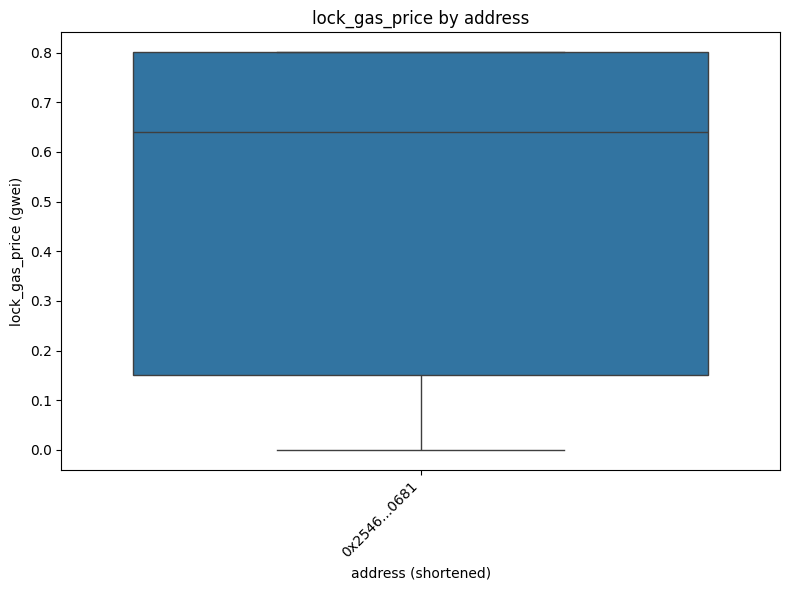

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "created": created, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, created, txn, gas in lst
])

# set timezone +8
df["created"] = pd.to_datetime(df["created"] + 8 * 3600, unit="s")

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)

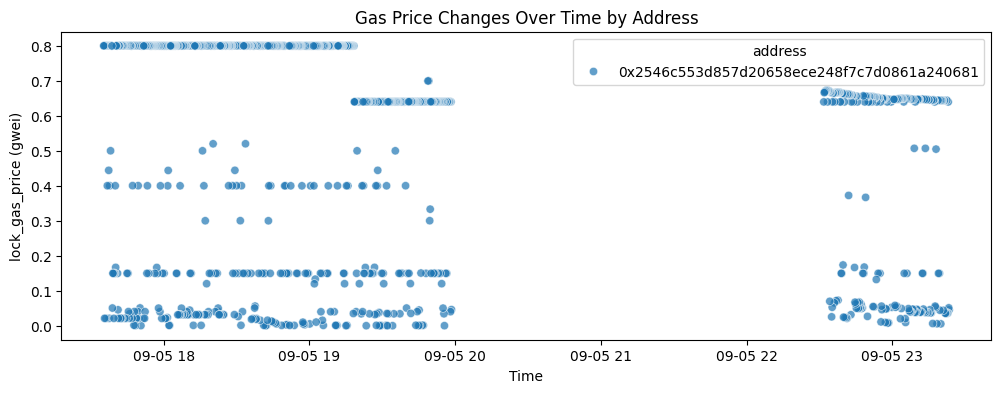

In [32]:
df["created_dt"] = pd.to_datetime(df["created"], unit="s")
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x="created_dt", y="lock_gas_price", hue="address", alpha=0.7)
plt.title("Gas Price Changes Over Time by Address")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()

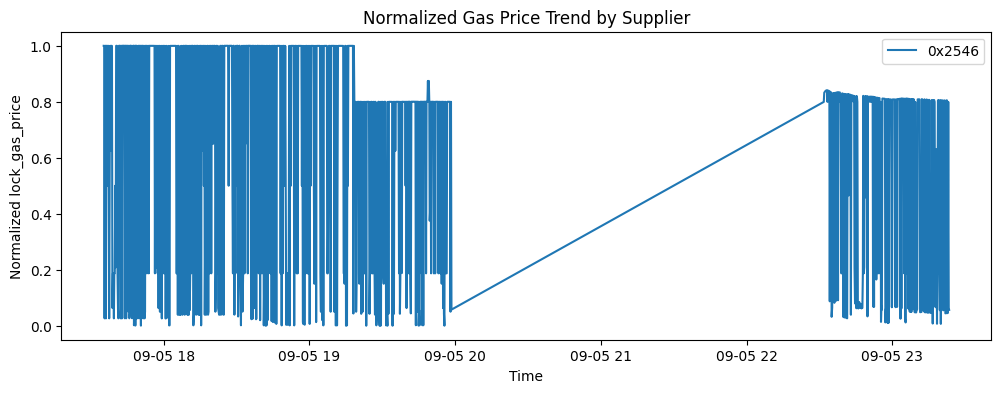

In [33]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    norm = (group["lock_gas_price"] - group["lock_gas_price"].min()) / (group["lock_gas_price"].max() - group["lock_gas_price"].min())
    plt.plot(group["created_dt"], norm, label=addr[:6])
plt.legend()
plt.title("Normalized Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("Normalized lock_gas_price")
plt.show()

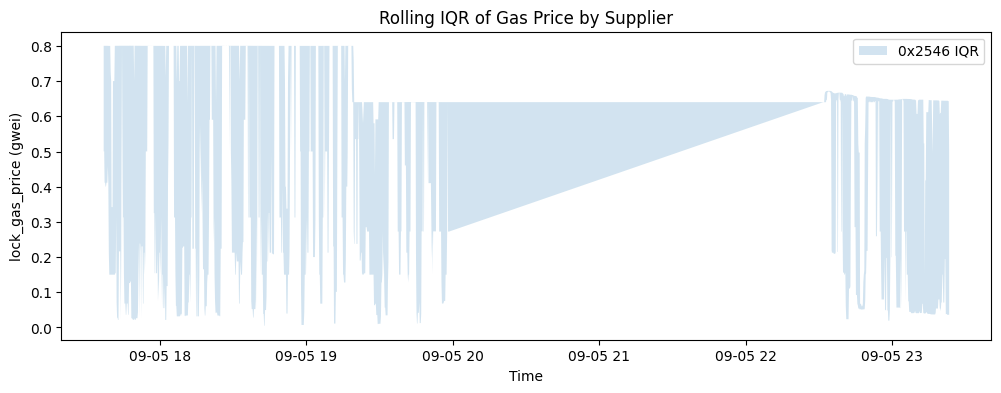

In [34]:
window = 10
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    rolling_q25 = group["lock_gas_price"].rolling(window).quantile(0.25)
    rolling_q75 = group["lock_gas_price"].rolling(window).quantile(0.75)
    plt.fill_between(group["created_dt"], rolling_q25, rolling_q75, alpha=0.2, label=f"{addr[:6]} IQR")
plt.legend()
plt.title("Rolling IQR of Gas Price by Supplier")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()


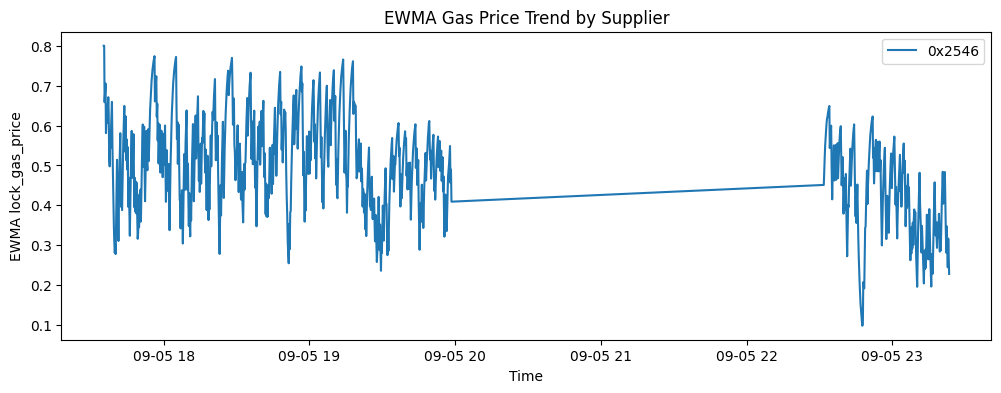

In [35]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    ewma = group["lock_gas_price"].ewm(span=10, adjust=False).mean()
    plt.plot(group["created_dt"], ewma, label=addr[:6])
plt.legend()
plt.title("EWMA Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("EWMA lock_gas_price")
plt.show()


### LOG

23:42 | 35.3T | $1,454.92 (@ $4,302.34/ETH)

Server Address Lookup Tool
==========================
Available servers: 0-29

可以调查一些这几个机器的网络和内存吗？这几个经常报错

Server Lookup Results:
======================
Valid servers found:
  Server 18: 60.12.103.231
  Server 26: 60.12.103.251
  Server 27: 60.12.103.208

In [36]:
2600000000 / 1e9

2.6